In [1]:
#setup
data_dir='../../Data/Weather'
# file_index='BBBSBBBB'
file_index = 'BSSSBSBB'
meas='PRCP'

# Reconstruction using top eigen-vectors
For measurement = {{meas}}

## Load the required libraries

In [ ]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [2]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.20.1 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=None


In [3]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

## Read Statistics File

In [4]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [5]:
#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==meas)
df.show(5)

+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|            coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|  82.56229124822084|-112.70396095353047| 226.35876439411504|     45.7|BSSSBSBB| 31.5475| -88.5172|       PRCP|0.8489488119013486|0.8460458438210778|0.8361358007932939|0.8500722647172128|USC00221174|5314252.0|     2|[00 00 00 00 C0 5...|1991.0|
|-122.95862422146472

### Plot Mean and Eigenvecs

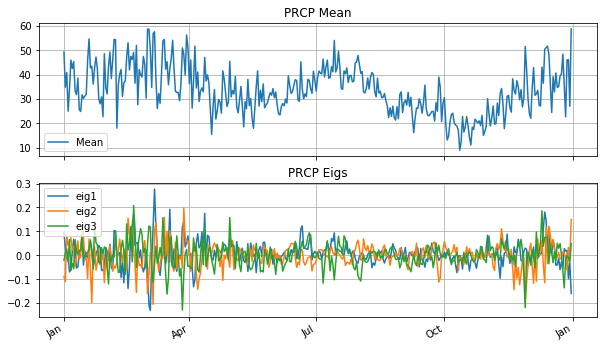

In [6]:
m=meas
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

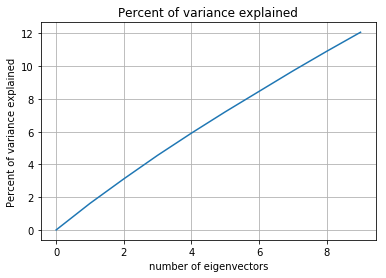

In [7]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [8]:
# A function for plotting the CDF of a given feature
def plot_CDF(df,feat):
    rows=df.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    while len(vals)< len(P):
        vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('fraction of instances')
    xlabel(feat)
    grid()
    

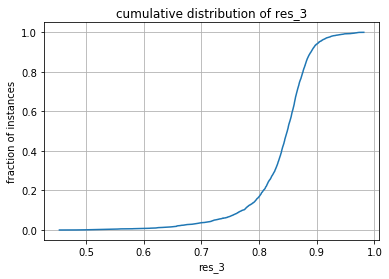

In [9]:
plot_CDF(df,'res_3')

In [10]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
rows[0][:2]

(u'USC00221174', 1991.0)

In [11]:
days=set([r[1] for r in rows])
miny=min(days)
maxy=max(days)
record_len=int((maxy-miny+1)*365)
record_len

51100

In [12]:
## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector

In [13]:
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]

In [14]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

USC00012188 13771
USC00011810 10802
USC00016335 3578
USC00016334 5326
USW00063874 350
USC00221174 26356
US1ALEL0022 1084
US1ALEL0024 710
USC00018178 39863
USC00011315 362
USC00015354 14426
USW00023802 1782
USW00023801 1779
USC00015449 6723
USC00016684 14275
US1ALLE0007 1436
USC00012079 15108
USC00010140 25850
USC00014835 364
US1ALEL0016 329
USC00014830 334
US1ALEL0010 1362
USC00011301 14471
USC00011300 3986
USC00015116 10772
USC00016436 15753
USC00017620 9729
USW00063897 1800
USC00013816 38216
USC00015439 35069
US1ALWX0001 1725
US1ALWX0002 1691
USC00016218 28086
USC00013271 14751
US1ALEL0005 707
USC00012245 21353
USC00012240 20471
USC00015121 22111
USC00018215 19142
USC00018446 32449
US1ALBR0001 322
USC00014884 11269
US1ALCK0003 667
USC00014798 28235
US1ALCK0004 1345
USC00017366 41736
USC00015547 3185
USC00015420 11541
USC00015427 2778
USC00013308 7199
USW00073802 1443
USC00018859 38575
USW00013895 23644
US1ALAT0014 356
USC00011690 19619
USC00016161 9925
USC00015555 29460
USC00011189 1

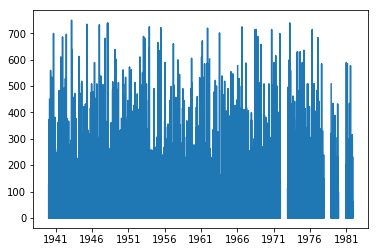

In [15]:
# plot(dates,All['USC00192812']);
plot(dates,All['USC00012188'])

In [16]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

(100L, 51100L)


(5110000L,) (1191097L,) (309963L,)


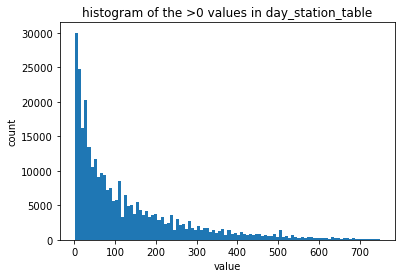

In [17]:
RT=day_station_table
F=RT.flatten()
NN=F[~np.isnan(F)]
NZ=NN[NN>0]
print shape(F),shape(NN),shape(NZ)

hist(NZ,bins=100);
title('histogram of the >0 values in day_station_table')
xlabel('value')
ylabel('count')

In [18]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_day=np.nanmean(day_station_table,axis=0)
mean_by_station=np.nanmean(day_station_table,axis=1)
tbl_minus_day = day_station_table-mean_by_day
tbl_minus_station = (day_station_table.transpose()-mean_by_station).transpose()

print 'total RMS                   = ',RMS(day_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-day   = ',RMS(tbl_minus_day)

C:\Users\udupa\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: Mean of empty slice


total RMS                   =  97.7834476074
RMS removing mean-by-station=  91.7634984587
RMS removing mean-by-day   =  64.082549661


In [19]:
#Normalize rows of RT to have norm 1
Len=sqrt(np.nansum(tbl_minus_day**2,axis=1))
NRT=(tbl_minus_day.transpose()/Len).transpose()

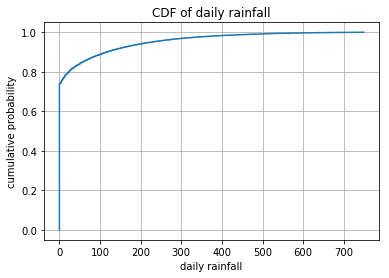

In [20]:
RT=day_station_table
F=RT.flatten()
NN=F[~np.isnan(F)]

NN.sort()
P=np.arange(0.,1.,1./len(NN))
plot(NN,P)
grid()
title('CDF of daily rainfall')
xlabel('daily rainfall')
ylabel('cumulative probability')

In [ ]:
K=5  # the number of time-shifts we consider
Middle=K/2 # the index (among K) of the zero-time-shift
n,m=RT.shape
TK=np.empty([n*K,m-K],dtype=numpy.float64)

#create the shifts
for i in range(K):
    TK[i::K,:]=NRT[:,i:-K+i]

#zero Nan entries and indicate them in a separate matrix
TKnan=np.isnan(TK)
TK[TKnan]=0
TK1nan=1-TKnan*1

TT=NRT[:,Middle:-Middle-1]
TTnan=np.isnan(TT)
TT1nan=1-TTnan*1
TT[TTnan]=0
print 'shape of sequence matrix (TT) %s, shape of matrix with %d shifts (TK) %s'%\
    (str(TT.shape),K,str(TK.shape))
#print sum(TK1nan,axis=1)
#print sum(TT1nan)

In [ ]:
Prod=np.dot(TK,TT.transpose())
print shape(Prod)
print sum(np.isnan(Prod.flatten()))

In [ ]:
hist(Prod[Prod>0.01].flatten(),bins=300);
xlim([0.0,1.1])
title('distribution of values in prod matrix')
grid()
#showmat(ProdMean[:100,:100].transpose())

In [ ]:
n,m

In [ ]:
_shift=np.empty([n,n])
_max=np.empty([n,n])
for i in range(n):
    Slice=Prod[i*K:(i+1)*K,:]
    _shift[i,:]=np.argmax(Slice,axis=0)  #find best shift
    _max[i,:]=np.max(Slice,axis=0) #find max correlation

In [ ]:
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.matshow(mat)

In [ ]:
_max2=_max*10.
_max2[_max2>1.]=1.
showmat(_max2)
#showmat(_max*(_max>0.2))

In [ ]:
_Sshift=_shift*(_max>0.01)
showmat(_Sshift)

In [ ]:
print min(_Sshift.flatten()),max(_Sshift.flatten())

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, svd_solver='full')
pca.fit(_max)     
#print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(cumsum(Var_explained))
grid()

In [ ]:
L=list(pca.components_.transpose())
X=sorted(L,key=lambda x:x[0]) 
plot(X);
#(key=lambda x:x[0])

In [ ]:
order=np.argsort(pca.components_[0,:])
_max_reord=_max[order,:]
_max_reord=_max_reord[:,order]
_max2=_max_reord*10.
_max2[_max2>1.]=1.
showmat(_max2)

In [ ]:
comp_=pca.components_
figure(figsize=(10,10))
print shape(comp_)
scatter(comp_[0,:],comp_[1,:]);